# Introduction to PyTorch

In [15]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Linear regression

### Data preparation

For this task we'll consider the problem of predicting the price of a house in Boston. The following code loads the data (`load_boston`) and represents them as `torch.Tensor`, a PyTorch-specific representation of a tensor (a tensor is a generalization of a matrix to more than 2 dimensions). The `dtype` parameter forces conversion to floating-point numbers.

In [16]:
from sklearn.datasets import load_boston
boston = load_boston()
X = torch.tensor(boston['data'], dtype=torch.float)
y = torch.tensor(boston['target'], dtype=torch.float)

We then split the data randomly into three subsets: a training set consisting of 70\% of the learning examples, a validation set consisting of 10\% and a test set consisting of the remaining 20\%.

In [17]:
n, p = X.shape
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
X = X[indices]
y = y[indices]
X_train = X[:n_train, :]
y_train = y[:n_train]
X_validation = X[n_train:n_train+n_validation, :]
y_validation = y[n_train:n_train+n_validation]
X_test = X[n_train+n_validation:, :]
y_test = y[n_train+n_validation:]

### Building a simple regressor

PyTorch is based on modules (objects of the class `torch.nn.Module`), which are composed into a compution graph. Each module may use parameters (objects of the class `torch.nn.Parameter`), and for each such an object it is possible to automatically compute gradients and optimize them according to some cost function.

We begin by constructing a single linear layer, that is, a layer implementing the operation $\hat{y} = Xw + b$

In [18]:
regressor = nn.Linear(p, 1) # p input features, 1 output feature

To evaluate the performance we use mean-squared error. While PyTorch offers a ready to use implementation as the class `torch.nn.MSELoss()`, this time we implement it manually as an example. The main point is to inherit from the class `torch.nn.Module` and then to override the method `forward`, which is responsible for performing computations in the forward direction of the computation graph. Computations in the backward direction (that is, gradient flow) are derrived automatically.

In [19]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

We would like to optimize the vector `w` and `b` automatically during the learning. To this end, we use the class `torch.optim.Adam`, which implements some extensions of the graident descent algorithm. We construct the object `opt`, which is responsible for optimizing the regressor's parameters, obtained by calling `regressor.parameters()`.

In [20]:
opt = optim.Adam(regressor.parameters())

### Starting computations

We implement mini-batch learning over `n_epoch` epochs. Within each epoch:
1. The indices of the training set are shuffled.
2. We iterate over these indices, retrieving `batch_size` of them every time. We use these indices to select examples used in the current learning step.
3. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
4. We execute the regressor and compute the mean-squared error (MSE).
5. We compute the gradients (`mse_value.backward()`) and apply them (`opt.step()`) to update the parameters of the regressor
6. We store the value of MSE. We call the `detach()` method to detach the MSE and its gradients.

After an epoch is completed, we average the collected MSEs and store the value.

In [21]:
mse_values = []
batch_size = 100
n_epoch = 1000
for epoch in range(n_epoch):
    indices = np.random.permutation(n_train)
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_train[indices_batch, :]
        y_batch = y_train[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.detach())
    mse_values.append(np.mean(mse_epoch))    

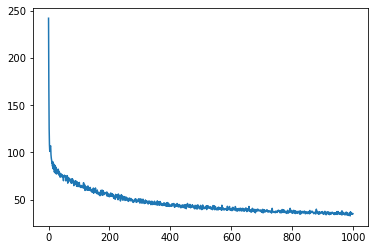

In [22]:
plt.plot(mse_values)
plt.show()

Execute the two preceeding cells of the code again. Because the regressor and the optimizer were not created anew, so the parameters are already optimized and the obtained charts are vastly different. In order to return to the initial state it is necessary to create new obiect `regressor` and `opt`.

### Task 1: Early stopping

Implement early stopping: after each epoch of learning compute the value of MSE using the sets `X_validation` i `y_validation`. Observe that we must call the methods
`regressor.train()` and `regressor.eval()` to switch the module between the training mode and the evaluation mode. Remeber not to call `opt.step()` after performing the computation on the validation set. Stop the learning process if there is no improvement over the last 100 epochs with regard to the value of MSE on the validation set. Store values of `mse` for training and for validation (respecitvely in `training_mses` and `validation_mses`) and plot them. Print out the number of the epoch when the learning process was stopped.

In [23]:
regressor = nn.Linear(p, 1) # p input features, 1 output feature
opt = optim.Adam(regressor.parameters())

training_mses = []
validation_mses = []
batch_size = 100
n_epoch = 10000
training_mses = []
validation_mses = []
best_valid_mse = float("inf")
epochs_siince_best_mse = 0
for epoch in range(n_epoch):
    regressor.train()
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_train[indices_batch, :]
        y_batch = y_train[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        mse_epoch.append(mse_value.detach())
        opt.step()
    training_mses.append(np.mean(mse_epoch))  
    regressor.eval()
    y_valid_pred = regressor(X_validation).reshape((-1,))
    cur_val_mse = mse(y_validation, y_valid_pred).detach()
    validation_mses.append(cur_val_mse)
    if cur_val_mse < best_valid_mse:
        best_valid_mse = cur_val_mse
        epochs_siince_best_mse = 0
    if epochs_siince_best_mse == 100:
        print("Epochs taken:", epoch+1)
        break
    epochs_siince_best_mse+=1

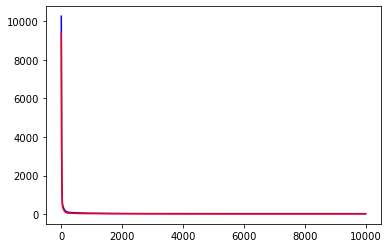

In [24]:
plt.plot(training_mses, 'b') # plot training errors in blue
plt.plot(validation_mses, 'r') # plot validation errors in red
plt.show()

### Task 2: L1 regularization

Implement the L1 regularization following the equation below by implementing the method `forward` in the class `MSEWithL1`

$$ cost = MSE + \alpha \sum_{i=1}^n \left|w_i\right| $$

Observe that the sum starts in 1, not in 0 - this is because the intercept is not included in this sum!

In [25]:
class MSEWithL1(nn.Module):
    
    def __init__(self, alpha, weight):
        super(MSEWithL1, self).__init__()
        self._weight = weight
        self._alpha = alpha
        
    def forward(self, pred, target):
        mse = ((pred-target)**2).mean()
        absolute = self._weight[1:].abs()
        sum_weights = absolute.sum()
        return mse+self._alpha*sum_weights

Test your solution: train for 5000 epochs for each of the following values of $\alpha$: 0.01, 0.1, 1, 10, 100. Every time create the regressor and the optimizer from scratch. Every epoch, collect MSE (not the total cost defined by `MSEWithL1`) on the validation set and plot them on a single chart for all tested values of alpha.

In [26]:
mse = MSE()

n_epochs = 5000
mses = {}
for alpha in [0.01, 0.1, 1, 10, 100]: 
    print("Alpha:", alpha)
    regressor = nn.Linear(p, 1)
    opt = optim.Adam(regressor.parameters())
    cost = MSEWithL1(alpha, regressor.weight)
    mses[alpha] = [] # store the MSE values on the validation set here
    for epoch in range(n_epochs):
        regressor.train()
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            indices_batch = indices[start:end]
            X_batch = X_train[indices_batch, :]
            y_batch = y_train[indices_batch]
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            cost_value = cost(y_pred, y_batch)
            cost_value.backward()
            opt.step()
        #Evaluation
        regressor.eval()
        y_valid_pred = regressor(X_validation).reshape((-1,))
        cur_val_mse = mse(y_validation, y_valid_pred).detach()
        mses[alpha].append(cur_val_mse)

Alpha: 0.01
Alpha: 0.1
Alpha: 1
Alpha: 10
Alpha: 100


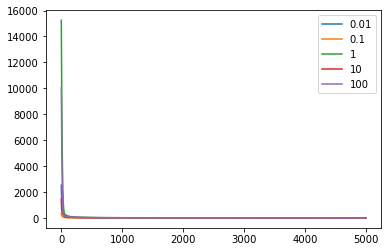

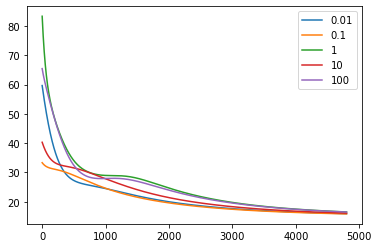

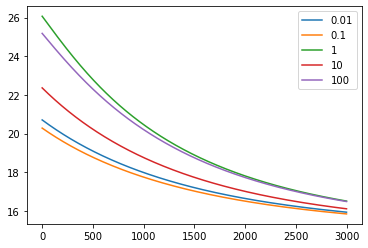

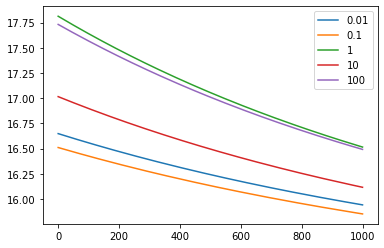

In [27]:
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][200:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][2000:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][4000:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()

**Which of the values of $\alpha$ is the best?**

alpha = 0.1 seems to be the best, because model with this parametern learn the fastest and has lowest error on validation set.

alpha = 100 is best,because  it makes our model learn really the fastest . All alpha values prevent overfitting almost equally effectively (after 5k iterations the error is almost the same.), so speed is the differentiating factor.

## Classification

The second part is concerned with the classification task. We begin by downloading the MNIST dataset, consisting of 70.000 examples of handwritten digits (0-9), represented as grayscale images of 28x28 pixels. We use the function `fetch_openml` that downloads the data from [https://www.openml.org/](https://www.openml.org).

In [32]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [33]:
X = torch.tensor(mnist.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist.target])

The following code splits the data into three subsets: training, validation and test. This time, instead of representing the sets as raw tensors, we wrap each of them into an object of the class `torch.utils.data.TensorDataset`, which then enables shuffling, grouping into mini-batches and iterating over using `torch.utils.data.DatasetLoader`.

In [34]:
n, p = mnist.data.shape
k = 10 # liczba klas
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
train_indices = indices[:n_train]
validation_indices = indices[n_train:n_train+n_validation]
test_indices = indices[n_train+n_validation:]

ds_train = data.TensorDataset(X[train_indices,:], y[train_indices])
ds_validation = data.TensorDataset(X[validation_indices,:], y[validation_indices])
ds_test = data.TensorDataset(X[test_indices,:], y[test_indices])

### Logistic regression

We create a simple logisitc regression model, learning on the raw pixels of the images. The matrix of the feature weights (here: pixels) is of the size $p \times k$, i.e., $p$ weights for each of the $k$ classes. The model computes logits, i.e., the output of the logistic  regression **before** applying the softmax function. In the output, each row corresponds to a single example and each column to a single class. Should each row be normalized using the softmax function, each row would be a probability distribution.

In [35]:
model = nn.Linear(p, k)

As the loss function we will use *cross entropy* and perform the optimization using the Adam optimizer.

In [36]:
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

We create an auxiliary function to compute the classification accuracy. For each row of the `logits` matrix we select the number of the column with the highest value and compare it with the expected (true) value. This way we obtain a vector of 0s and 1s, which are then averaged to compute the accuracy.

In [37]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

The remainder is very similar to the linear regression: during each of the `n_epoch` epochs, we enable the training mode (`model.train()`), create a data loder ( `torch.utils.data.DataLoader`) to handle shuffling and creating batches for us and then iterate over the loader, computing loss and gradients. Then we evaluate by computing the accuracy on the validation set.

In [38]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100

In [39]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)

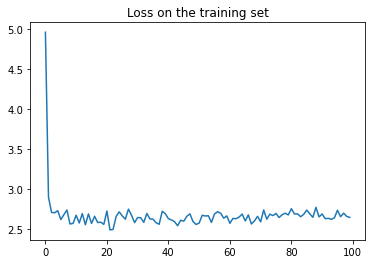

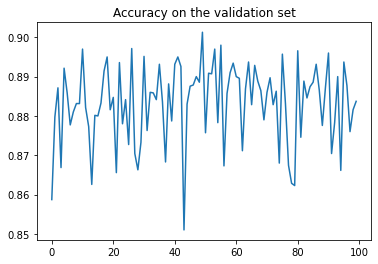

In [40]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

### Task 3: Early stopping

Copy and modify the code presented above so that it uses early stopping instead of training over a constant number of epochs.

In [41]:
loss_values = []
acc_values = []
batch_size = 100
epochs_to_stop = 40

In [42]:
cur_max_accur = float("-Inf")
epochs_since_max_accuracy = 0
while epochs_since_max_accuracy < epochs_to_stop:
    epochs_since_max_accuracy+=1
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)
    if acc > cur_max_accur:
        cur_max_accur = acc
        epochs_since_max_accuracy = 0

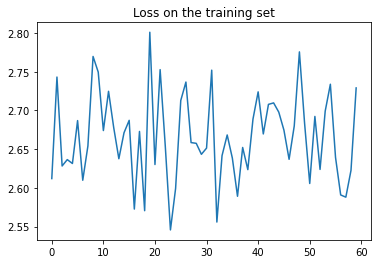

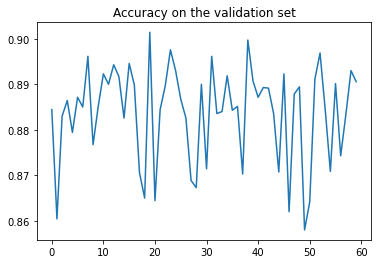

In [43]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

### Task 4: A neural network with a hidden layer

A logistic regression is a neural network without hidden layers. Use the code presented above and extend it with a hidden layer of 500 neurons. In order to connect a few objects of the type `torch.nn.Module` into a sequence use the class `torch.nn.Sequence`. Use the leaky ReLU function (`torch.nn.LeakyReLU`) to implement non-linearity. 

Implement early stopping. During the training collect the loss and accuracy on the  training set and the accuracy on the validation set and plot them. If the training takes too much time, modify `batch_size` and/or the number of neurons in the hidden layer.

In [79]:
net = nn.Sequential(*[
    nn.Linear(p,500),
    nn.LeakyReLU(),
    nn.Linear(500,k)
])

cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [80]:
loss_values = []
acc_values = []
batch_size = 100
epochs_to_stop = 50

In [81]:
cur_max_accur = float("-Inf")
epochs_since_max_accuracy = 0
while epochs_since_max_accuracy < epochs_to_stop:
    epochs_since_max_accuracy+=1
    net.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = net(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    net.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = net(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)
    if acc > cur_max_accur:
        cur_max_accur = acc
        epochs_since_max_accuracy = 0

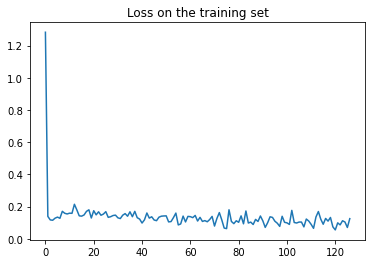

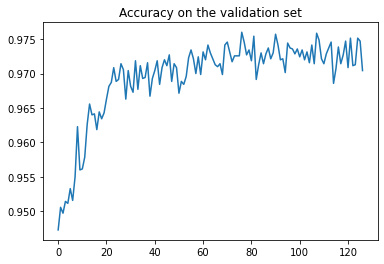

In [82]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()